In [7]:
from IPython.display import IFrame, Image, display, HTML
def myiframe(url):
    return IFrame(url, width=700, height=350)
def myiframe2(url):
    return HTML('<iframe src={} width=700 height=350></iframe>'.format(url))
def myimgdisplay(url):
    i = Image(filename=url)
    return display(i)

# Python tools for Space Mission Analysis
### a.k.a 'planetary remote sensing'
* Michael Aye
* Laboratory for Atmospheric Space Physics
* Boulder, Colorado

# Who am I
* PhD in High Energy Gamma-Ray Astrophysics (Durham, UK)
* Changed to local solar system (for various reasons)

* Dawn mission to asteroid belt : camera SS (MPS, Germany)
    * Ion engines are real!
* BepiColombo mission to Mercury : laser altimeter (Bern, CH)

* LRO mission at the Moon : Diviner radiometer (UCLA)
* Cassini image and UV data analysis (Boulder, CO)
* Maven UV instrument calibration (Boulder, CO)

* Science: CO$_2$ jets on Mars (see later in the talk)
* Python **_user_** and advocator since 2004 (v2.2)

## Standard remote sensing work tasks
* Retrieve data
    * from multiple sources
    * with different resolutions, in space and time
* Observables mostly depend on many variables
    * Need to isolate dependencies to achieve best signal to noise
    * machine learning is applicable, not done much yet

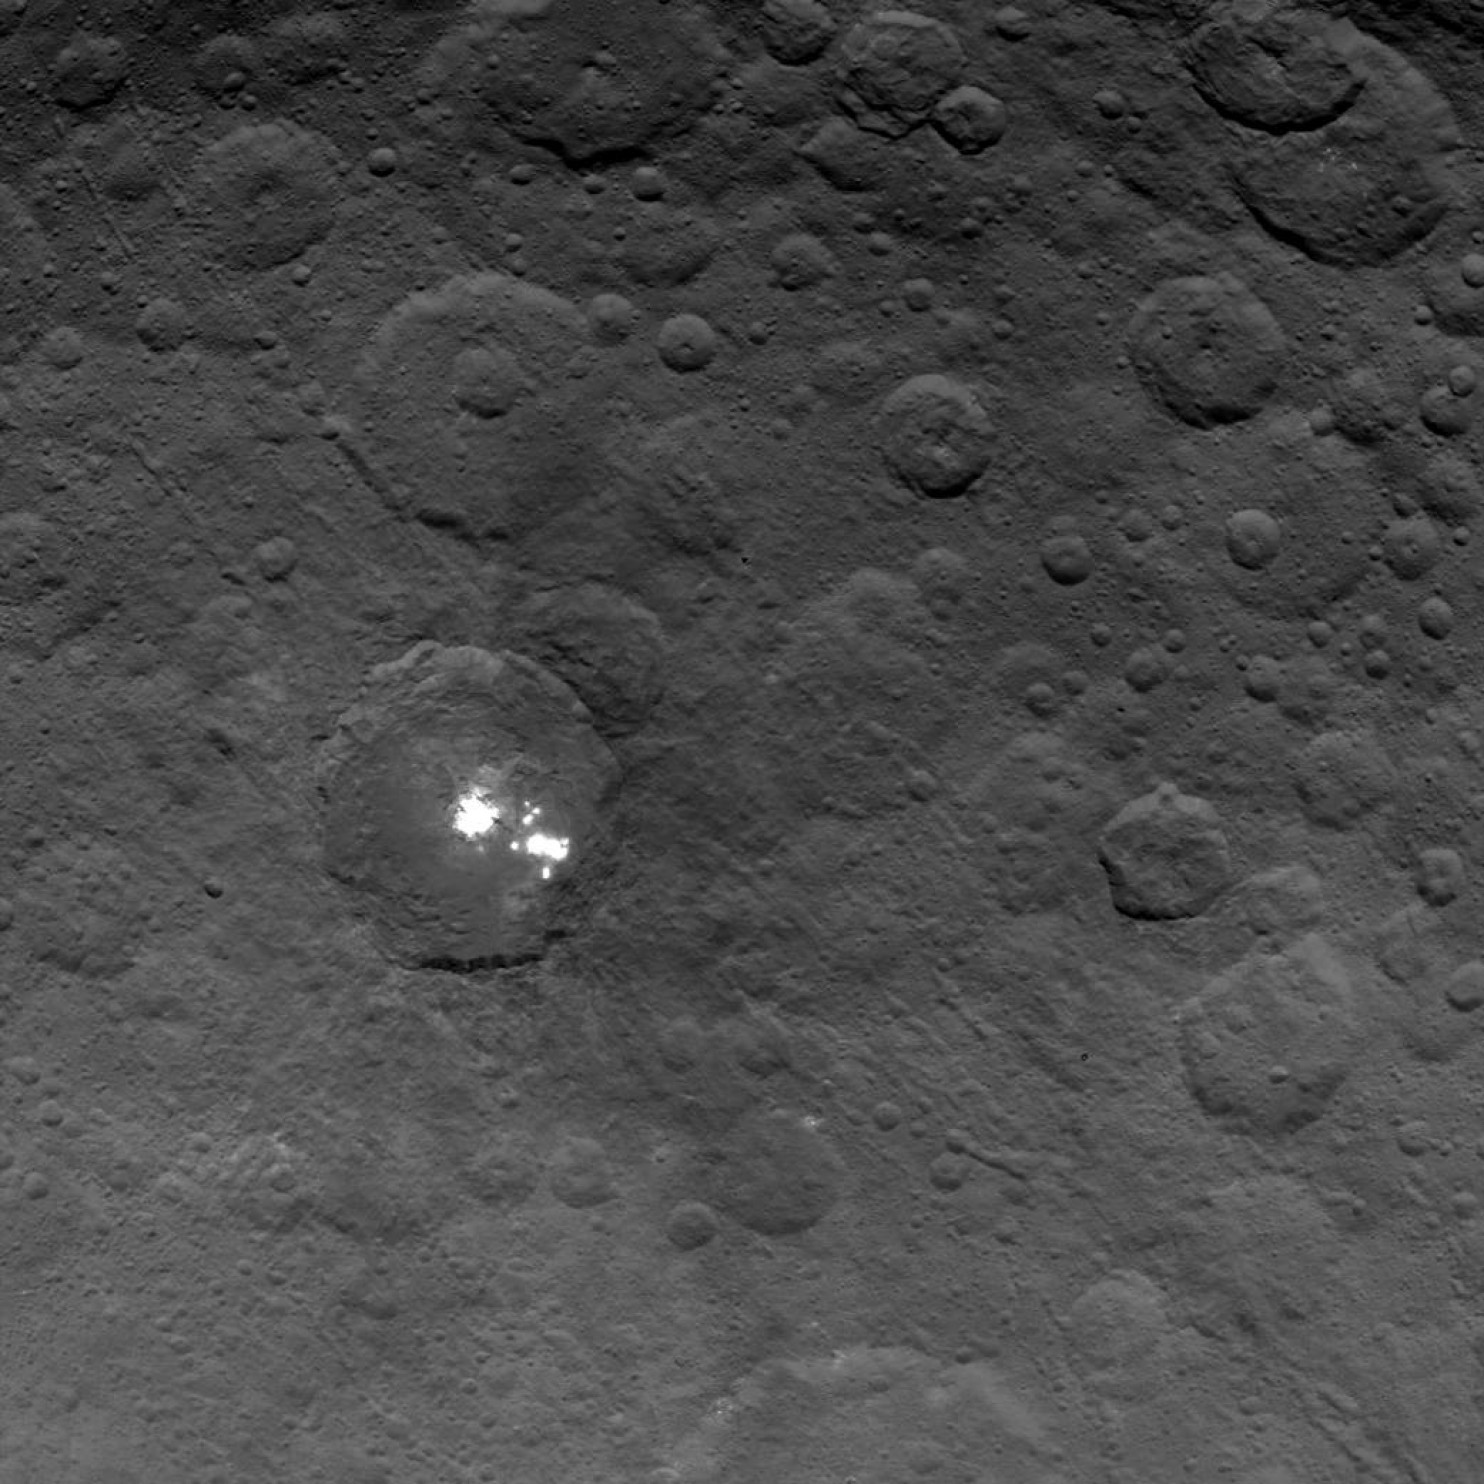

In [26]:
myimgdisplay('./imrs.php.jpeg')

## Discuss 3 tool areas
* Cassini ISS
    * Data retrieval and processing
* LRO Diviner 
    * discontinous category labeling in time-series
* TBD

# Cassini ISS interface library: pyciss
* Available now: http://github.com/michaelaye/pyciss
* Use cases
    * Downloading
    * Calibration pipeline and processing

## Use case 1: Downloading
* Read about image number N1695760475_1 in paper
* Cassini images are available at http://tools.pds-rings.seti.org/opus/
* Would need to learn how interface works
    * not too hard, but want automation

In [4]:
myiframe('http://tools.pds-rings.seti.org/opus')

* OPUS website offers URL request-based JSON API
    * does that sound right?
    * (I have no idea what I'm talking about)

* ...
    * .. but I wrapped it.. ;)
    * All search criteria seen above reachable
    * Wrapped only the ones I need but easily extendable

In [5]:
from pyciss import opusapi
opus = opusapi.OPUS()

In [19]:
opus.get_filename('N1695760475_1')

Found 1 obsids.


[Raw:
 Label:
 http://pds-rings.seti.org/volumes/COISS_2xxx/COISS_2069/data/1695427520_1695761375/N1695760475_1.LBL
 Image:
 http://pds-rings.seti.org/volumes/COISS_2xxx/COISS_2069/data/1695427520_1695761375/N1695760475_1.IMG
 Calibrated:
 Label:
 http://pds-rings.seti.org/derived/COISS_2xxx/COISS_2069/data/1695427520_1695761375/N1695760475_1_CALIB.LBL
 Image:
 http://pds-rings.seti.org/derived/COISS_2xxx/COISS_2069/data/1695427520_1695761375/N1695760475_1_CALIB.IMG]

In [20]:
opus.r.url

'http://pds-rings-tools.seti.org/opus/api/files.json?primaryfilespec=N1695760475_1'

In [21]:
[i for i in dir(opus) if not i.startswith('_')]

['create_files_request',
 'create_images_request',
 'create_request_with_query',
 'download_previews',
 'download_results',
 'get_between_resolutions',
 'get_details',
 'get_filename',
 'get_image',
 'get_radial_res_query',
 'obsids',
 'r',
 'show_images',
 'unpack_json_response']

In [12]:
opus.show_images(size='med')

In [24]:
opus.download_results()

In [25]:
# Projected ring resolution
opus.get_between_resolutions(0.5, 0.7)

Found 69 obsids.


## Use case 2: Calibration pipeline
* Images exist in calibrated form in PDS
* Often though, newer calibration available (ISIS)
* This depends heavily on ISIS:
    * Integrated Software for Imagers and Spectrometers
    * http://isis.astrogeology.usgs.gov

In [ ]:
# %load ~/Dropbox/src/pyciss/pyciss/pipeline.py
from __future__ import division, print_function
from pysis.isis import ciss2isis, cisscal, spiceinit, ringscam2map, getkey,\
    editlab, dstripe, isis2std
from pysis.util import file_variations
from pysis import IsisPool
import gdal
import numpy as np
from os.path import join as pjoin
import os
from pyciss import plotting
from pyciss.io import dataroot
from . import io

ISISDATA = os.environ['ISIS3DATA']

def calibrate_ciss(img_name, name_only=False):
    (cub_name,
     cal_name,
     dst_name,
     map_name) = file_variations(img_name,
                                 ['.cub',
                                  '.cal.cub',
                                  '.dst.cal.cub',
                                  '.map.dst.cal.cub'])
    if name_only:
        return map_name
    ciss2isis(from_=img_name, to=cub_name)
    targetname = getkey(from_=cub_name,
                        grp='instrument',
                        keyword='targetname')
    # forcing the target name to Saturn here, because some observations of
    # the rings have moons as a target, but then the standard map projection
    # onto the Saturn ring plane fails.
    # see also
    # https://isis.astrogeology.usgs.gov/IsisSupport/index.php/topic,3922.0.html
    if targetname.lower() != 'saturn':
        editlab(from_=cub_name, options='modkey',
                keyword='TargetName', value='Saturn',
                grpname='Instrument')
    spiceinit(from_=cub_name, cksmithed='yes', spksmithed='yes',
              shape='ringplane')
    cisscal(from_=cub_name, to=cal_name)
    dstripe(from_=cal_name, to=dst_name, mode='horizontal')
    ringscam2map(from_=dst_name, to=map_name,
                 map=pjoin(ISISDATA,
                           'base/templates/maps/ringcylindrical.map'))
    isis2std(from_=map_name, to=map_name[:-3]+'tif', format='tiff')
    return map_name



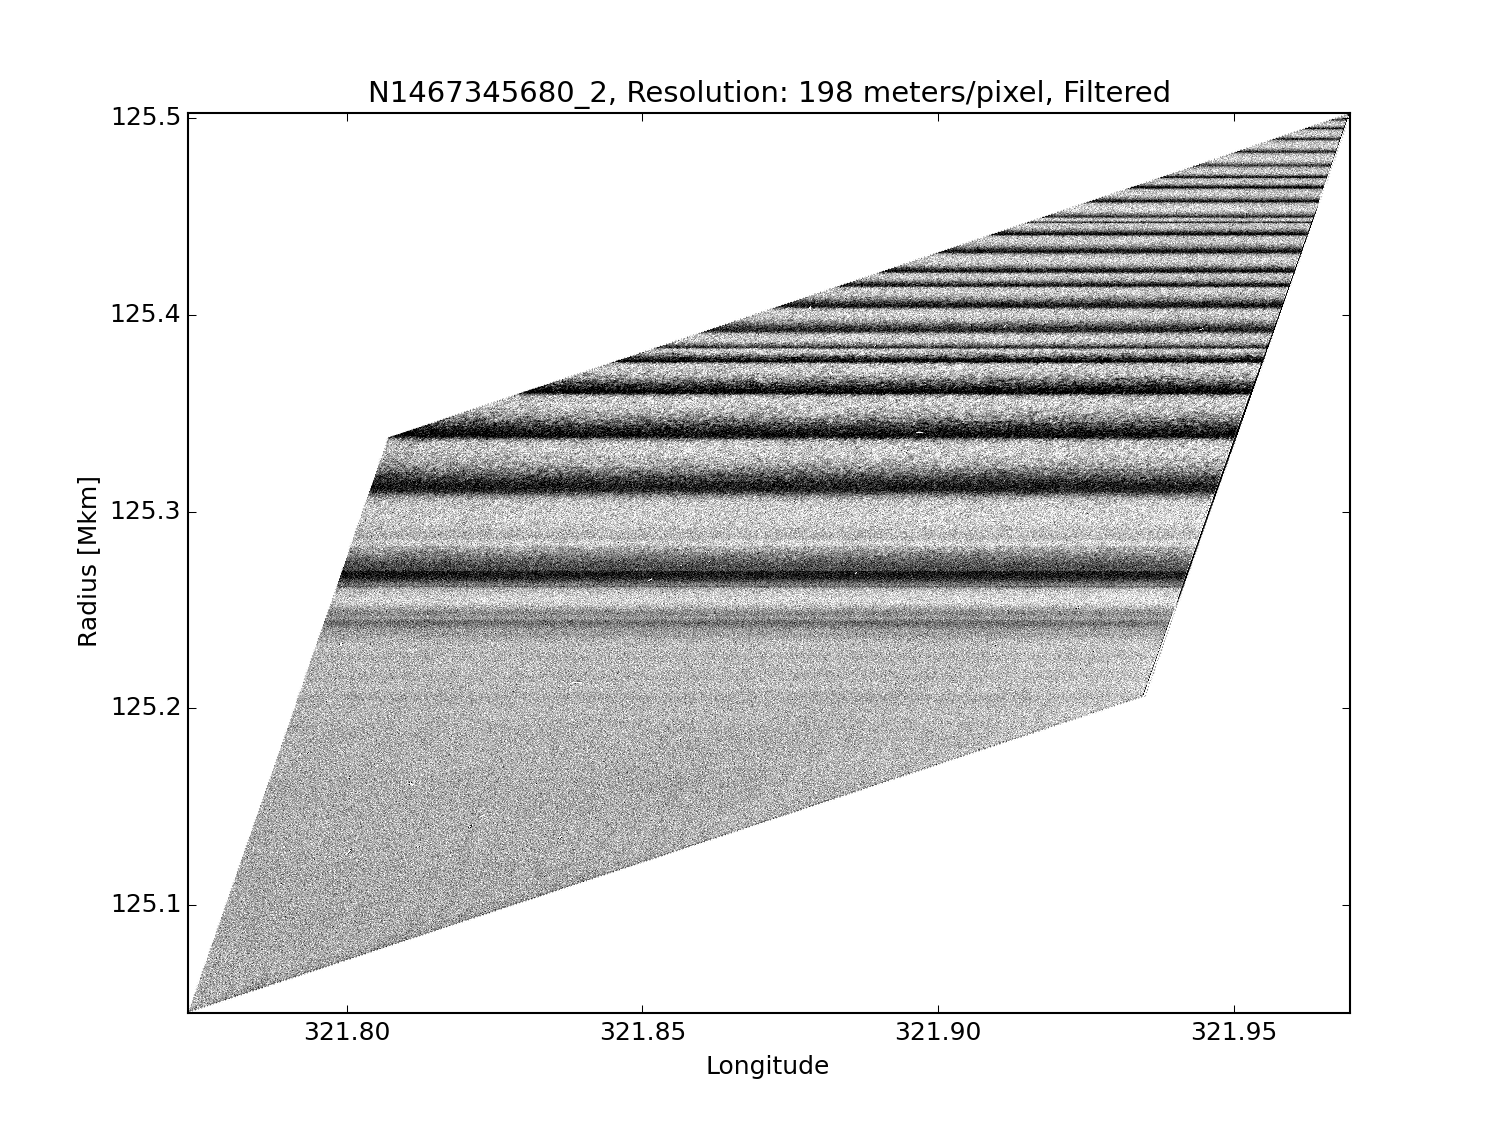

In [6]:
myimgdisplay('./N1467345680_2_Filtered.png')

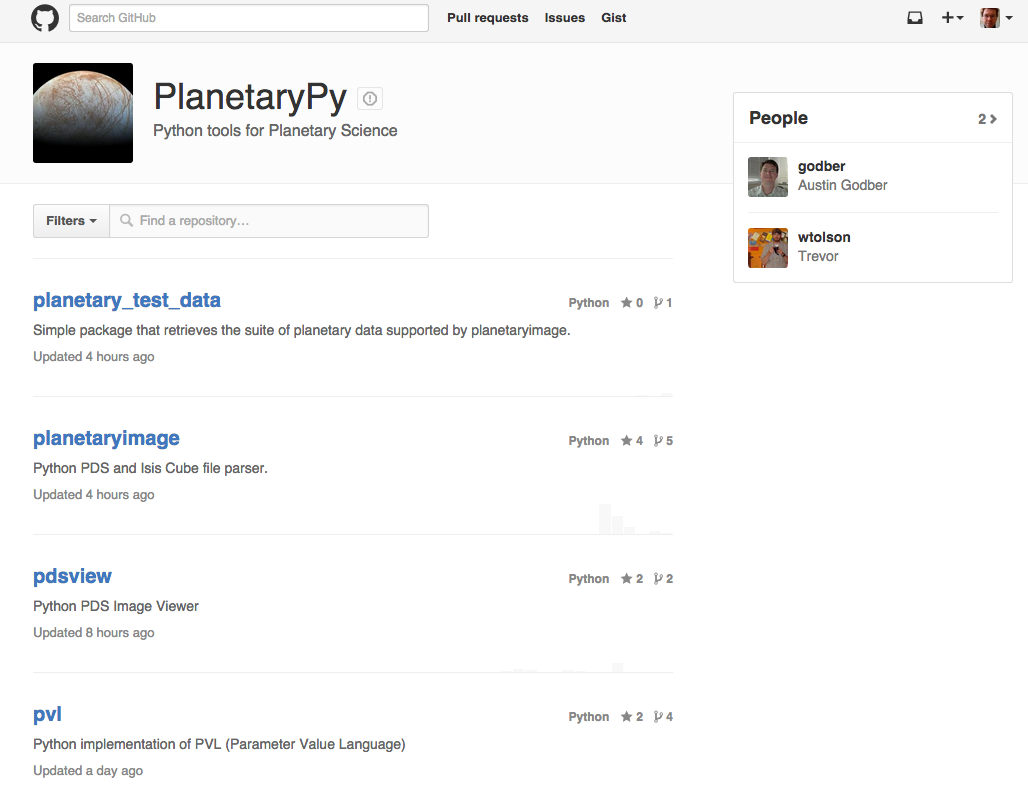

In [54]:
myimgdisplay('./Screenshot 2015-07-09 22.52.51.png')

notebook available at https://github.com/michaelaye/scipy2015